In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2 as cv
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import seaborn as sns

In [2]:
def load_data(path_data = 'dataset/'):    
    data = []
    labels = []
    file_name = []
    
    for sub_folder in os.listdir(path_data):
        sub_folder_files = os.listdir(os.path.join(path_data, sub_folder))
        for i, filename in enumerate(sub_folder_files):
            img_path = os.path.join(path_data, sub_folder, filename)
            
            img = cv.imread(img_path)
            img = img.astype(np.uint8)
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            img = cv.resize(img, (300, 300))
            
            data.append(img)
            labels.append(sub_folder)
            file_name.append(filename)
            
    print(len(data), len(labels), len(file_name))
    return data, labels, file_name


In [3]:
data, labels, file_name = load_data('dataset/')

300 300 300


In [4]:
from augmen import ImageAugmentor
output_path = 'augment/'
augmentor = ImageAugmentor(data, labels, file_name, 'augment')
augmentor.augment_data()
data, labels, file_name = load_data('augment/')

600 600 600


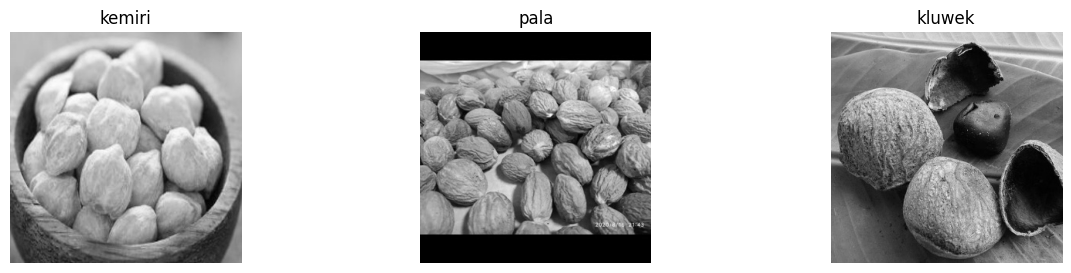

In [5]:
sample_data = []
sample_labels = []
for label in set(labels):
    idx = labels.index(label)
    sample_data.append(data[idx])
    sample_labels.append(labels[idx])

# Display the samples using matplotlib.pyplot
fig, axs = plt.subplots(1, len(set(labels)), figsize=(15, 3))
for i, (img, label) in enumerate(zip(sample_data, sample_labels)):
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title(label)
    axs[i].axis('off')
plt.show()

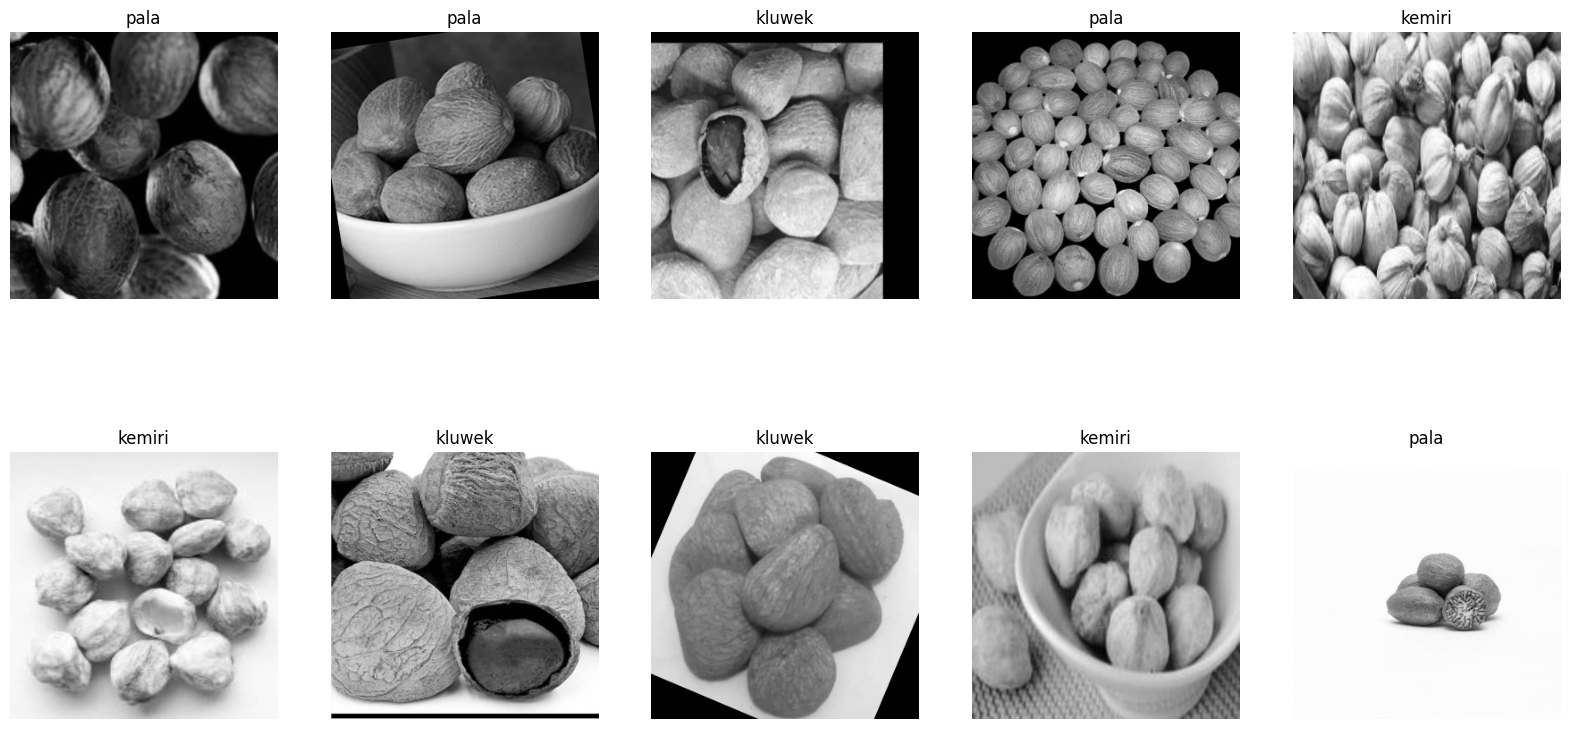

In [6]:
import random as rand

fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for i in range(2):
	for j in range(5):
		rand_index = rand.randint(0, len(data))
		ax[i, j].imshow(data[rand_index], cmap='gray')
		ax[i, j].set_title(labels[rand_index])
		ax[i, j].axis('off')
plt.show()

In [7]:
def glcm(image, derajat):
    directions = {
        0: (0, 1),
        45: (-1, 1),
        90: (-1, 0),
        135: (-1, -1)
    }
    if derajat not in directions:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    d = directions[derajat]
    max_val = 256
    glcm = np.zeros((max_val, max_val))
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if 0 <= i + d[0] < image.shape[0] and 0 <= j + d[1] < image.shape[1]:
                glcm[image[i, j], image[i + d[0], j + d[1]]] += 1

    glcm /= glcm.sum()
    return glcm

def calc_properties(glcm):
    I, J = np.ogrid[0:glcm.shape[0], 0:glcm.shape[1]]
    contrast = np.sum(glcm * (I - J) ** 2)
    dissimilarity = np.sum(glcm * np.abs(I - J))
    homogeneity = np.sum(glcm / (1.0 + (I - J) ** 2))
    ASM = np.sum(glcm ** 2)
    energy = np.sqrt(ASM)
    entropy = -np.sum(glcm * np.log2(glcm + (glcm == 0)))
    mean_i = np.sum(I * glcm)
    mean_j = np.sum(J * glcm)
    std_i = np.sqrt(np.sum((I - mean_i) ** 2 * glcm))
    std_j = np.sqrt(np.sum((J - mean_j) ** 2 * glcm))
    correlation = np.sum(((I - mean_i) * (J - mean_j) * glcm) / (std_i * std_j + (std_i * std_j == 0)))
    
    return contrast, dissimilarity, homogeneity, ASM, energy, entropy, correlation

# Data processing
angles = [0, 45, 90, 135]
properties = ["Contrast", "Dissimilarity", "Homogeneity", "ASM", "Energy", "Entropy", "Correlation"]
results = {f"{prop}{angle}": [] for angle in angles for prop in properties}

for img in data:
    for angle in angles:
        glcm_matrix = glcm(img, angle)
        props = calc_properties(glcm_matrix)
        for prop, value in zip(properties, props):
            results[f"{prop}{angle}"].append(value)

dataTable = {'Filename': file_name, 'Label': labels}
dataTable.update(results)

df = pd.DataFrame(dataTable)
df.to_csv('hasilEkstraksi.csv', index=False)

hasilEkstrak = pd.read_csv('hasilEkstraksi.csv')

<Axes: >

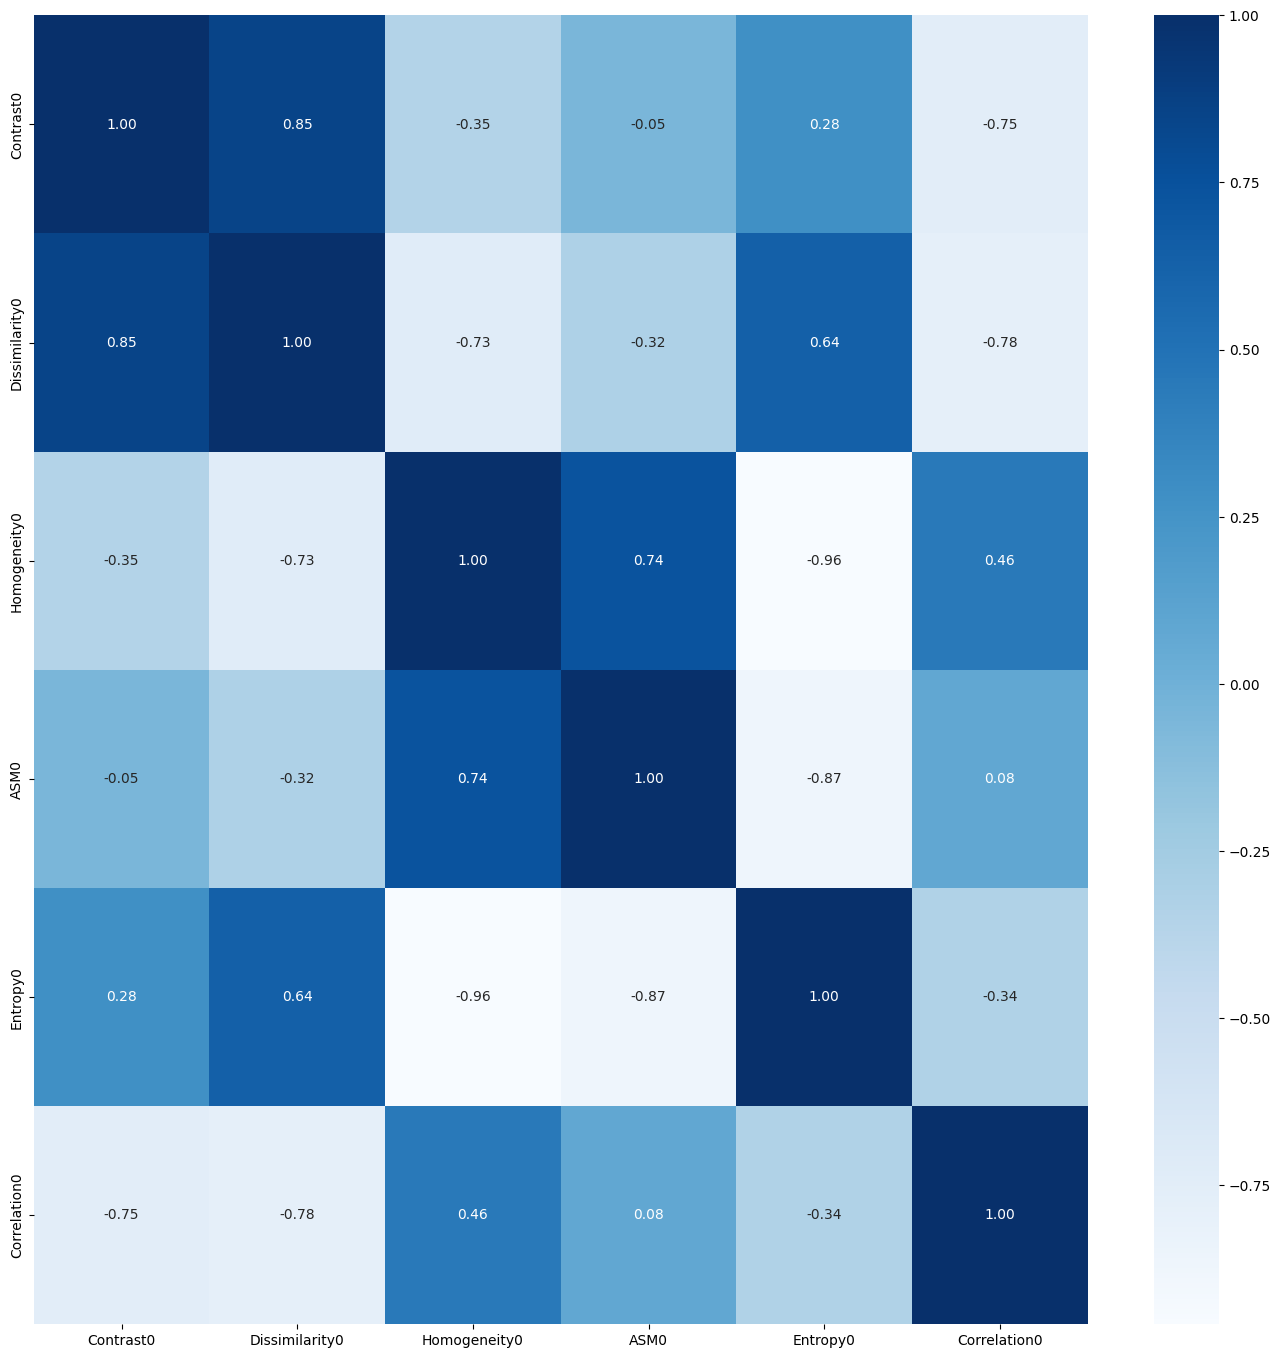

In [8]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.9
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

In [9]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3, random_state=42)
print(X_train)
print(X_test)

      Contrast0  Dissimilarity0  Homogeneity0      ASM0   Entropy0  \
108   15.361616        2.257001      0.465815  0.005549  10.096425   
272  195.666778        8.393735      0.237776  0.017914  11.687873   
599  156.040312        3.068495      0.642003  0.135256   7.090070   
479   72.997101        4.352843      0.295467  0.000911  10.923049   
436  345.752219        6.649097      0.723884  0.470838   4.911431   
..          ...             ...           ...       ...        ...   
71   241.157603        5.786165      0.516600  0.126496   8.378788   
106   67.033122        2.931984      0.447142  0.015078  10.135358   
270  115.219253        5.532609      0.330489  0.005057  11.344404   
435   85.068149        5.324627      0.301412  0.010486  11.183235   
102  106.261839        2.635507      0.549047  0.029349   9.298086   

     Correlation0  
108      0.994987  
272      0.977400  
599      0.989902  
479      0.978722  
436      0.927710  
..            ...  
71       0.950773  

In [10]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [11]:
def crossValidation(x, y, model):
    y_pred = cross_val_predict(model, x, y, cv=20)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='macro', zero_division=1)
    recall = recall_score(y, y_pred, average='macro')
    f1 = f1_score(y, y_pred, average='macro')
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1 Score: {f1 * 100:.2f}%')
    return y_pred, accuracy, precision, recall, f1


print("KNN")
y_pred_knn, akurasiKNN, presisiKNN, recallKNN, f1KNN = crossValidation(x_new, y, KNeighborsClassifier(n_neighbors=20))

print("\nRandom Forest")
y_pred_rforest, akurasiRForest, presisiRForest, recallRForest, f1RForest = crossValidation(x_new, y, RandomForestClassifier(n_estimators=175, random_state=42))

print("\nSVM")
y_pred_svm, akurasiSVM, presisiSVM, recallSVM, f1SVM = crossValidation(x_new, y, SVC(kernel='rbf', random_state=42))

KNN
Accuracy: 44.50%
Precision: 43.08%
Recall: 44.50%
F1 Score: 42.33%

Random Forest
Accuracy: 55.17%
Precision: 55.17%
Recall: 55.17%
F1 Score: 54.99%

SVM
Accuracy: 41.17%
Precision: 40.03%
Recall: 41.17%
F1 Score: 38.62%


In [12]:
from sklearn.metrics import confusion_matrix

# KNN
y_pred_knn = crossValidation(x_new, y, KNeighborsClassifier(n_neighbors=20))[0]
conf_mat_knn = confusion_matrix(y, y_pred_knn)

# Random Forest
y_pred_rforest = crossValidation(x_new, y, RandomForestClassifier(n_estimators=175, random_state=42))[0]
conf_mat_rforest = confusion_matrix(y, y_pred_rforest)

# SVM
y_pred_svm = crossValidation(x_new, y, SVC(kernel='rbf', random_state=42))[0]
conf_mat_svm = confusion_matrix(y, y_pred_svm)


Accuracy: 44.50%
Precision: 43.08%
Recall: 44.50%
F1 Score: 42.33%
Accuracy: 55.17%
Precision: 55.17%
Recall: 55.17%
F1 Score: 54.99%
Accuracy: 41.17%
Precision: 40.03%
Recall: 41.17%
F1 Score: 38.62%


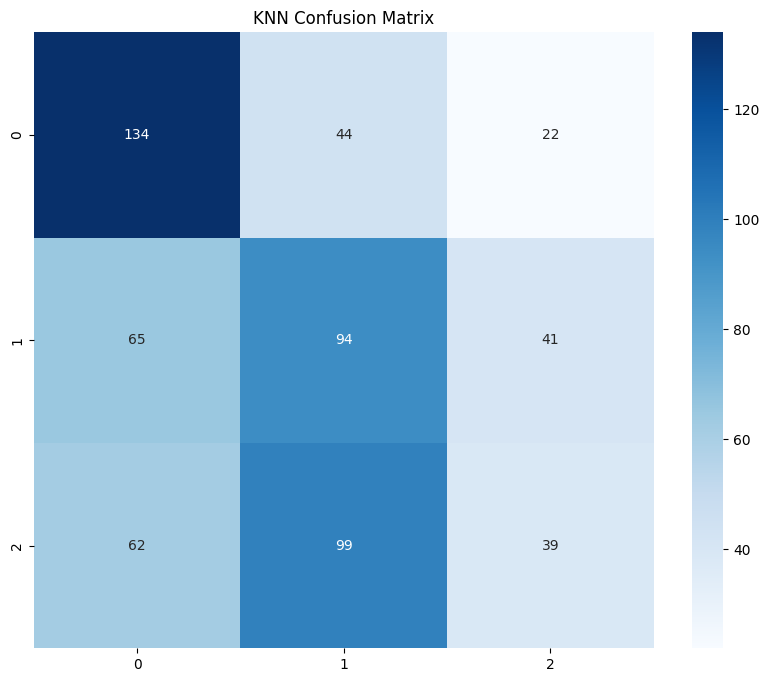

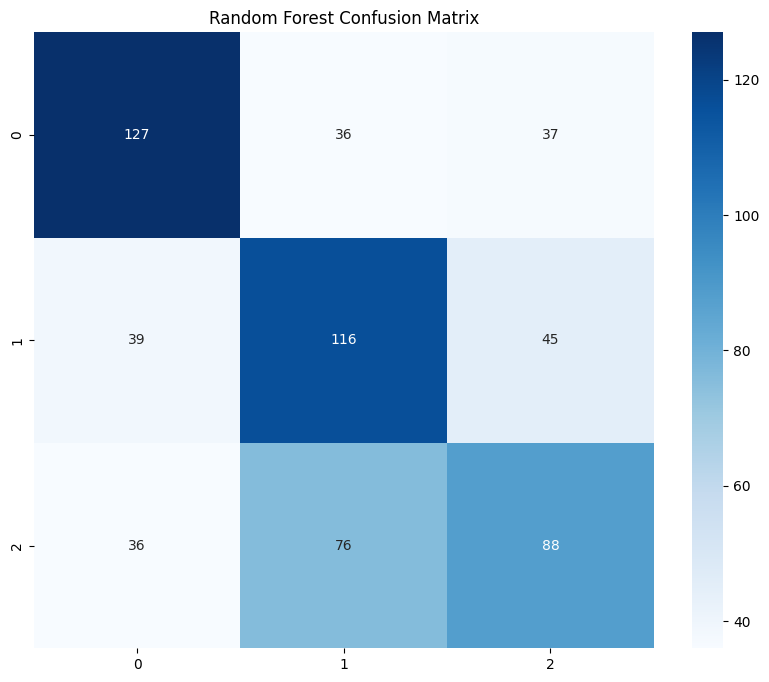

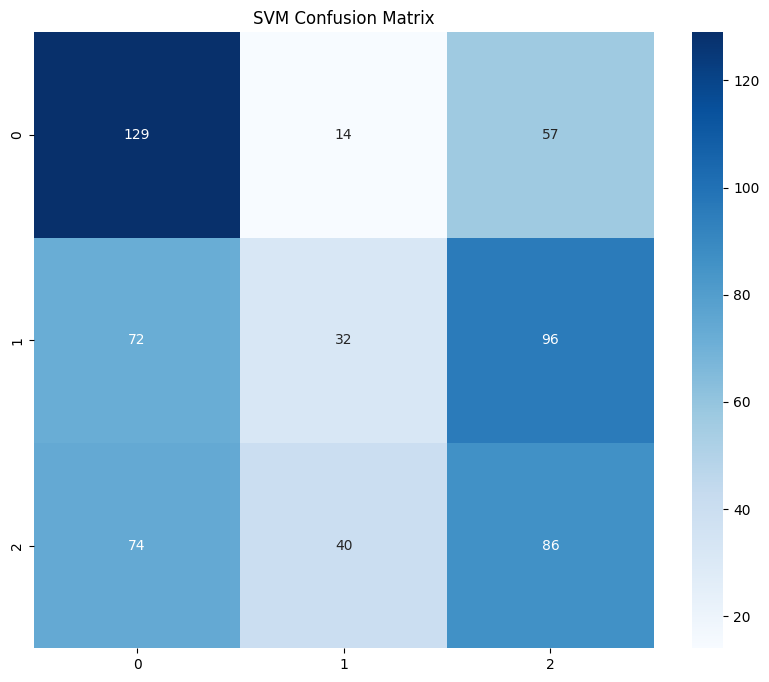

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_knn, annot=True, cmap="Blues", fmt="d")
plt.title("KNN Confusion Matrix")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_rforest, annot=True, cmap="Blues", fmt="d")
plt.title("Random Forest Confusion Matrix")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_svm, annot=True, cmap="Blues", fmt="d")
plt.title("SVM Confusion Matrix")
plt.show()
